# Question 1


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import math
import skimage
from skimage.feature import blob_log


Range of sigma values used: 2 - 40
The maximum initial radius (before adjustment): 36.0
The maximum adjusted radius: 50.91168824543143


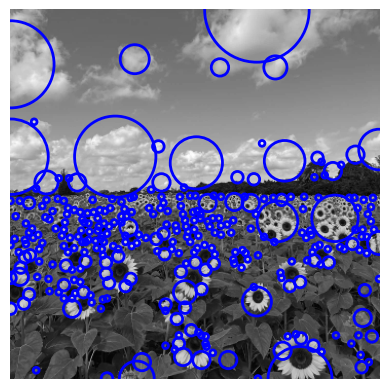

In [32]:
# Load the original image with reduced color resolution
image_original = cv.imread("Images/New folder/the_berry_farms_sunflower_field.jpeg", cv.IMREAD_REDUCED_COLOR_4)

# Convert the image to grayscale
image_gray = cv.cvtColor(image_original, cv.COLOR_BGR2GRAY)

# Detect blobs using the Laplacian of Gaussian (LoG) method
blobs_log = blob_log(image_gray, min_sigma=2, max_sigma=40, num_sigma=20, threshold=0.1)

# Find the maximum radius of the detected blobs before adjustment
max_initial_radius = max(blobs_log[:, 2])

# Adjust the detected blobs' sizes by multiplying the radius by sqrt(2)
# This step adjusts the radii to more accurately reflect blob size
blobs_log[:, 2] = blobs_log[:, 2] * math.sqrt(2)

# Find the maximum radius after adjustment
max_adjusted_radius = max(blobs_log[:, 2])

# Create a figure and axis to display the grayscale image
fig, ax = plt.subplots()
ax.imshow(image_gray, cmap='gray')  # Display the grayscale image
ax.axis('off')  # Hide axis for better visualization

# Loop through each detected blob and draw a circle around it
for blob in blobs_log:
    y, x, radius = blob  # Extract blob coordinates and radius
    # Create a circular patch around each blob
    circle = plt.Circle((x, y), radius, color='blue', linewidth=2, fill=False)
    ax.add_patch(circle)  # Add the circle to the plot

# Print information about sigma range and maximum blob radius
print('Range of sigma values used: 2 - 40')
print(f'The maximum initial radius (before adjustment): {max_initial_radius}')
print(f'The maximum adjusted radius: {max_adjusted_radius}')

# Show the plot with detected blobs
plt.show()

# Question 2

In [59]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def ransac_line_estimation(X, ax, max_iterations=100, line_data_points_ratio=0.4, line_threshold=1.0):
    N = X.shape[0]
    line_data_points = int(line_data_points_ratio * N)
    line_best_error = np.inf
    line_sample = 2
    best_model = []
    best_line_inliers = []

    def cons(p):
        return (p[0]**2) + (p[1]**2) - 1

    constraint = ({'type': 'eq', 'fun': cons})

    def total_LSE(x, indices):
        a, b, d = x[0], x[1], x[2]
        error = np.square(a * X[indices, 0] + b * X[indices, 1] - d)
        return np.sum(error)

    def consensus_set(X, x, threshold):
        a, b, d = x[0], x[1], x[2]
        error = np.abs(a * X[:, 0] + b * X[:, 1] - d)
        return (error < threshold)

    i = 0
    while i < max_iterations:
        line_indices = np.random.randint(0, N, line_sample)
        x0 = np.array([1, 1, 0])
        res = minimize(total_LSE, x0=x0, args=(line_indices), tol=1e-6, constraints=constraint)
        inliers = consensus_set(X, res.x, line_threshold)

        if np.sum(inliers) > line_data_points:
            x0 = res.x
            res = minimize(total_LSE, x0=x0, args=(inliers), tol=1e-6, constraints=constraint)

            if res.fun < line_best_error:
                line_best_error = res.fun
                best_model = res.x
                best_line_inliers = inliers

                print(f"\nIteration: {i}")
                print(f"Line best error: {res.fun}")
                print(f"Best line indices: {line_indices}")
                print(f"Best model for the line: {res.x}")
                print(f"Total number of inliers: {np.sum(inliers)}")

        i += 1

    # Plot the line
    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = (-best_model[0] * x_ + best_model[2]) / best_model[1]
    ax.plot(x_, y_, color='c', label='RANSAC Line')
    ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='r', label='Line Inliers')

    return best_model, best_line_inliers



In [60]:
def ransac_circle_estimation(remnants, ax, max_iterations=100, c_threshold=1.0, c_num_data=35):
    c_best_error = np.inf
    c_sample = 3
    c_best_model = []
    c_best_inliers = []

    def c_total_LSE(x, indices):
        x0, y0, r = x
        x1, y1 = remnants[indices].T
        error = (np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2
        return np.sum(error)

    def c_consensus_set(remnants, x, threshold):
        distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
        return distances < threshold

    i = 0
    while i < max_iterations:
        c_indices = np.random.randint(0, len(remnants), c_sample)
        x0 = np.array([0, 0, 0])
        res = minimize(c_total_LSE, x0, args=c_indices, tol=1e-6)
        c_inliers = c_consensus_set(remnants, res.x, c_threshold)

        if np.sum(c_inliers) > c_num_data:
            x0 = res.x
            res = minimize(c_total_LSE, x0=x0, args=(c_inliers), tol=1e-6)

            if res.fun < c_best_error:
                c_best_error = res.fun
                c_best_model = res.x
                c_best_inliers = c_inliers

                print(f"\nIteration: {i}")
                print(f"Circle best error: {c_best_error}")
                print(f"Best circle indices: {c_indices}")
                print(f"Best model for circle: {c_best_model}")
                print(f"Total number of inliers: {np.sum(c_best_inliers)}")

        i += 1

    # Plot the circle
    circle = plt.Circle((c_best_model[0], c_best_model[1]), c_best_model[2], color='c', fill=False, label='RANSAC Circle')
    ax.add_patch(circle)
    ax.scatter(remnants[c_best_inliers, 0], remnants[c_best_inliers, 1], color='k', label='Circle Inliers')

    return c_best_model, c_best_inliers




-----------------------------Implement Line Estimation--------------------------------

Iteration: 2
Line best error: 9.622560654234555
Best line indices: [68 80]
Best model for the line: [0.71967441 0.69431171 1.56999929]
Total number of inliers: 41
------------------------------------Implement Circle Estimation----------------------------------------------
Number of inliers: 41
Number of remnants: 59

Iteration: 3
Circle best error: 6.8506182137768405
Best circle indices: [38 24 32]
Best model for circle: [1.64747479 3.17848198 9.66543595]
Total number of inliers: 37


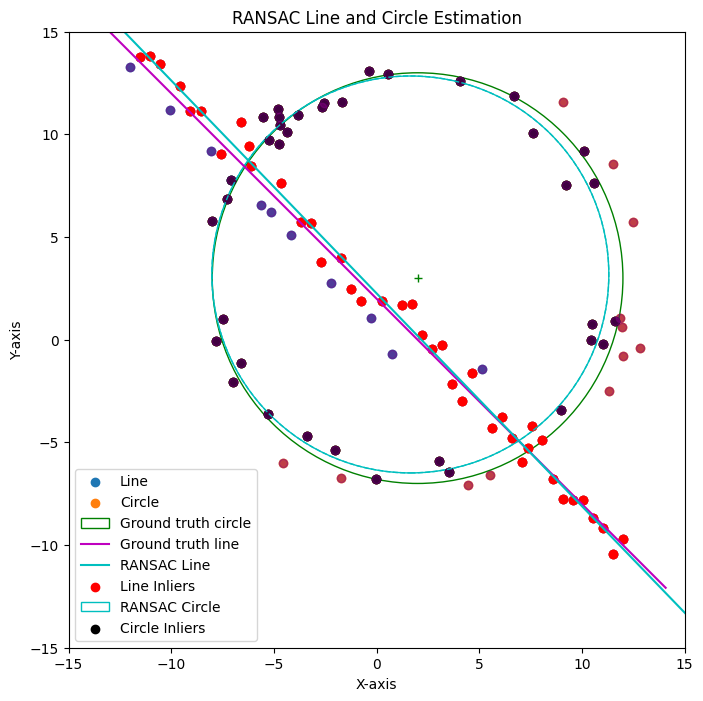

In [61]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
# np.random.seed (0)
N = 100
half_n = N//2

r = 10
x0_gt, y0_gt = 2, 3     # Center
s = r/16

t = np.random.uniform (0, 2*np.pi ,half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r+n)*np.cos(t), y0_gt + (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1 ), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n ,1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))     # All points

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(X_line[:, 0], X_line [:, 1], label= 'Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label= 'Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


# Estimating line using RANSAC
print('-----------------------------Implement Line Estimation--------------------------------')
best_line_model, best_line_inliers = ransac_line_estimation(X, ax)

# Extracting the outliers to use for circle estimation
line_outliers = np.where(best_line_inliers == False)[0]
remnants = X[line_outliers]

# Estimating circle using RANSAC
print('------------------------------------Implement Circle Estimation----------------------------------------------')
print(f"Number of inliers: {np.sum(best_line_inliers)}")
print(f"Number of remnants: {len(remnants)}")
best_circle_model, best_circle_inliers = ransac_circle_estimation(remnants, ax)

# Final plot adjustments and display
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])
ax.set_aspect('equal', 'box')
ax.legend()
plt.title("RANSAC Line and Circle Estimation")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Display additional elements
ax.scatter(X[best_line_inliers, 0], X[best_line_inliers, 1], color='r', label='Line Inliers')
ax.scatter(remnants[best_circle_inliers, 0], remnants[best_circle_inliers, 1], color='k', label='Circle Inliers')
ax.scatter(remnants[:, 0], remnants[:, 1], color='purple', label='Circle Sample Points', alpha=0.5)

# Show RANSAC Circle
circle_ransac = plt.Circle((best_circle_model[0], best_circle_model[1]), best_circle_model[2], color='c', fill=False, linestyle='--', label='RANSAC Circle')
ax.add_patch(circle_ransac)

plt.show()

# Question 3


Original Image shape: (768, 1024, 3)
Overlay Image shape: (960, 1920, 3)
Selected Points: [(227, 157), (211, 445), (465, 302), (458, 485)]
Transformation Matrix: 
[[-1.05370008e-02  5.27959775e-01  2.27000000e+02]
 [ 1.45352455e-01  3.32919126e-01  1.57000000e+02]
 [-1.04439216e-05  6.02243244e-04  1.00000000e+00]]


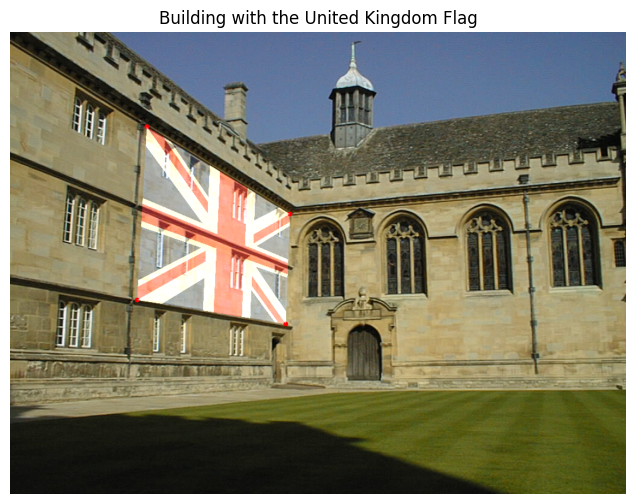

In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def mouse_click_handler(event, x, y, flags, param):
    # Handle mouse clicks to collect points for image warping
    global selected_points

    if event == cv.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        cv.circle(original_image, (x, y), 4, (0, 0, 255), -1)
        
        # Update the displayed image with selected points
        cv.imshow('Original Image', original_image)

# Load the base and overlay images
original_image = cv.imread('Images/New folder/005.jpg')
overlay_image = cv.imread('Images/New folder/flag.png')

# Show the original image for point selection
cv.imshow('Original Image', original_image)
cv.setMouseCallback('Original Image', mouse_click_handler)

# Initialize a list to store selected points
selected_points = []

# Collect four points in the order: top-left, bottom-left, top-right, bottom-right
while len(selected_points) < 4:
    cv.waitKey(1)  # Keep waiting for user input
cv.destroyAllWindows()

# Set source and destination points for homography transformation
dest_points = np.array(selected_points).astype(np.float32)
height, width = overlay_image.shape[:2]
src_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Compute the homographic transformation matrix
transformation_matrix = cv.getPerspectiveTransform(src_points, dest_points)

# Apply the perspective transformation to the overlay image
transformed_image = cv.warpPerspective(overlay_image, transformation_matrix, (original_image.shape[1], original_image.shape[0]))

# Blend the two images together with a specified opacity
blend_opacity = 0.5  # Adjust this value for different blending effects
final_image = cv.addWeighted(original_image, 1, transformed_image, blend_opacity, 0)


print("Original Image shape:", original_image.shape)
print("Overlay Image shape:", overlay_image.shape)
print("Selected Points:", selected_points)
print('Transformation Matrix: ')
print(transformation_matrix)


# Display the final blended image
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title('Building with the United Kingdom Flag')
plt.axis('off')  # Hide axis for a cleaner look
plt.show()


Original Image shape: (600, 800, 3)
Overlay Image shape: (618, 1100, 3)
Selected Points: [(76, 104), (454, 131), (183, 484), (447, 312)]
Transformation Matrix: 
[[9.82876303e-01 3.13168318e-01 7.60000000e+01]
 [2.08995745e-01 9.85237077e-01 1.04000000e+02]
 [1.40801749e-03 7.65186664e-04 1.00000000e+00]]


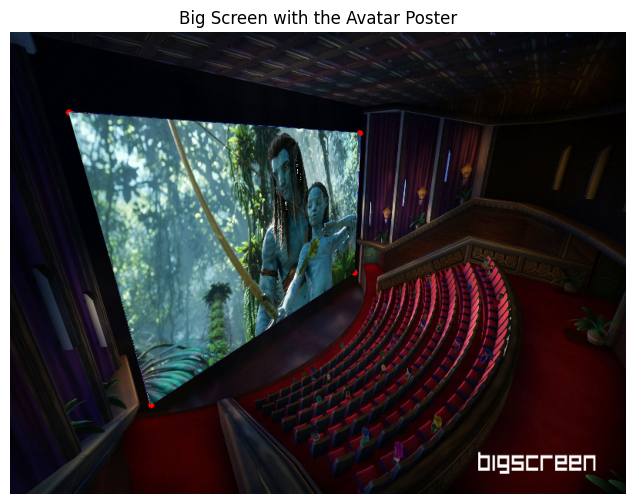

In [57]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def mouse_click_handler(event, x, y, flags, param):
    # Handle mouse clicks to collect points for image warping
    global selected_points

    if event == cv.EVENT_LBUTTONDOWN:
        selected_points.append((x, y))
        cv.circle(original_image, (x, y), 4, (0, 0, 255), -1)
        
        # Update the displayed image with selected points
        cv.imshow('Original Image', original_image)

# Load the base and overlay images
original_image = cv.imread('Images/New folder/billboard.jpg')
original_image = cv.resize(original_image, (800, 600))
overlay_image = cv.imread('Images/New folder/ava.jpg')

# Show the original image for point selection
cv.imshow('Original Image', original_image)
cv.setMouseCallback('Original Image', mouse_click_handler)

# Initialize a list to store selected points
selected_points = []

# Collect four points in the order: top-left, bottom-left, top-right, bottom-right
while len(selected_points) < 4:
    cv.waitKey(1)  # Keep waiting for user input
cv.destroyAllWindows()

# Set source and destination points for homography transformation
dest_points = np.array(selected_points).astype(np.float32)
height, width = overlay_image.shape[:2]
src_points = np.float32([[0, 0], [width, 0], [0, height], [width, height]])

# Compute the homographic transformation matrix
transformation_matrix = cv.getPerspectiveTransform(src_points, dest_points)

# Apply the perspective transformation to the overlay image
transformed_image = cv.warpPerspective(overlay_image, transformation_matrix, (original_image.shape[1], original_image.shape[0]))

# Create a mask from the transformed image, assuming black (0,0,0) is the transparent part
overlay_mask = cv.cvtColor(transformed_image, cv.COLOR_BGR2GRAY)
_, mask_inv = cv.threshold(overlay_mask, 1, 255, cv.THRESH_BINARY)

# Black-out the area of the overlay image in the original image
masked_original = cv.bitwise_and(original_image, original_image, mask=cv.bitwise_not(mask_inv))

# Take only the region of the transformed overlay image
masked_overlay = cv.bitwise_and(transformed_image, transformed_image, mask=mask_inv)

# Combine the images: paste the overlay on the original image
final_image = cv.add(masked_original, masked_overlay)

# Output information for debugging purposes
print("Original Image shape:", original_image.shape)
print("Overlay Image shape:", overlay_image.shape)
print("Selected Points:", selected_points)
print('Transformation Matrix: ')
print(transformation_matrix)

# Display the final image
plt.figure(figsize=(12, 6))
plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for display
plt.title('Big Screen with the Avatar Poster')
plt.axis('off')  # Hide axis for a cleaner look
plt.show()


# Question 4

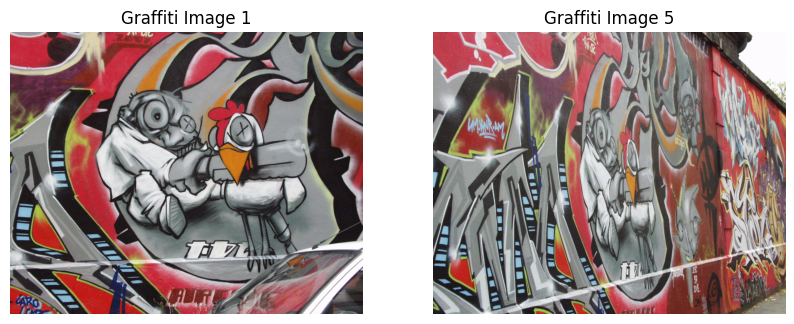

In [24]:
img1, img2 = cv.imread("Images/New folder/graf/graf/img1.ppm"), cv.imread("Images/New folder/graf/graf/img5.ppm")
img1, img2 = cv.cvtColor(img1, cv.COLOR_BGR2RGB), cv.cvtColor(img2, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('Graffiti Image 1')
ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Graffiti Image 5')
plt.show()

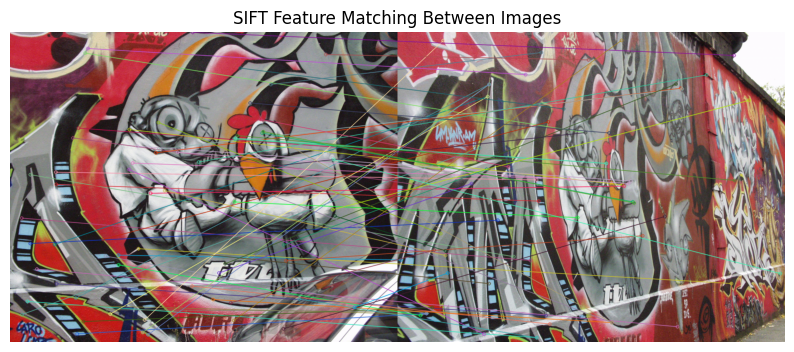

In [45]:
# Initialize the SIFT detector
sift_detector = cv.SIFT_create()

# Detect keypoints and compute descriptors for both images
keypoints_img1, descriptors_img1 = sift_detector.detectAndCompute(img1, None)
keypoints_img2, descriptors_img2 = sift_detector.detectAndCompute(img2, None)

# Create a Brute-Force Matcher for descriptor matching
matcher = cv.BFMatcher()
knn_matches = matcher.knnMatch(descriptors_img1, descriptors_img2, k=2)

# Apply the ratio test to filter good matches
good_matches = []
img1_points = []
img2_points = []

for match1, match2 in knn_matches:
    if match1.distance < 0.75 * match2.distance:
        good_matches.append(match1)
        img1_points.append(keypoints_img1[match1.queryIdx].pt)
        img2_points.append(keypoints_img2[match1.trainIdx].pt)

# Convert matched keypoints into NumPy arrays
img1_points = np.array(img1_points)
img2_points = np.array(img2_points)

# Draw the matches between the two images
matched_image = cv.drawMatchesKnn(img1, keypoints_img1, img2, keypoints_img2, [good_matches], None, flags=2)

# Plot the matched features
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('SIFT Feature Matching Between Images')
ax.imshow(matched_image)
ax.axis('off')  # Hide the axis for a cleaner display
plt.show()


In [46]:
def compute_homography(src_points, dst_points):
    # Calculate the mean of the source and destination points
    src_mean, dst_mean = np.mean(src_points, axis=0), np.mean(dst_points, axis=0)

    # Compute the scale factors based on the distribution of points
    src_scale = len(src_points) * np.sqrt(2) / np.sum(np.sqrt(np.sum((src_points - src_mean) ** 2, axis=1)))
    dst_scale = len(dst_points) * np.sqrt(2) / np.sum(np.sqrt(np.sum((dst_points - dst_mean) ** 2, axis=1)))

    # Compute translation components for normalization matrices
    tx_src, ty_src = -src_scale * src_mean[0], -src_scale * src_mean[1]
    tx_dst, ty_dst = -dst_scale * dst_mean[0], -dst_scale * dst_mean[1]

    # Construct normalization matrices
    T_src = np.array([[src_scale, 0, tx_src], [0, src_scale, ty_src], [0, 0, 1]])
    T_dst = np.array([[dst_scale, 0, tx_dst], [0, dst_scale, ty_dst], [0, 0, 1]])

    A = []

    # Construct the matrix A for solving homography using SVD
    for i in range(len(src_points)):
        src_point_hom = T_src @ np.concatenate((src_points[i], [1])).reshape(3, 1)
        dst_point_hom = T_dst @ np.concatenate((dst_points[i], [1])).reshape(3, 1)

        A.append([-src_point_hom[0][0], -src_point_hom[1][0], -1, 0, 0, 0, 
                  dst_point_hom[0][0] * src_point_hom[0][0], dst_point_hom[0][0] * src_point_hom[1][0], dst_point_hom[0][0]])
        A.append([0, 0, 0, -src_point_hom[0][0], -src_point_hom[1][0], -1, 
                  dst_point_hom[1][0] * src_point_hom[0][0], dst_point_hom[1][0] * src_point_hom[1][0], dst_point_hom[1][0]])

    # Convert A to numpy array and perform SVD
    A = np.array(A)
    _, _, V = np.linalg.svd(A, full_matrices=True)

    # Extract the last row of V and reshape it into the homography matrix
    h = np.reshape(V[-1], (3, 3))

    # Denormalize the homography matrix
    homography_matrix = np.linalg.inv(T_dst) @ h @ T_src

    # Normalize the homography matrix
    homography_matrix = (1 / homography_matrix.item(8)) * homography_matrix
    
    return homography_matrix


In [47]:
def point_distance(point1, point2, homography_matrix):
    # Convert point1 and point2 to homogeneous coordinates
    point1_homogeneous = np.array([point1[0], point1[1], 1])
    point2_homogeneous = np.array([point2[0], point2[1], 1])

    # Estimate the corresponding point2 from point1 using the homography matrix
    estimated_point2 = np.dot(homography_matrix, point1_homogeneous.T)

    # Normalize the estimated point to convert it back from homogeneous coordinates
    estimated_point2 = (1 / estimated_point2[2]) * estimated_point2

    # Return the Euclidean distance between the actual point2 and the estimated point2
    return np.linalg.norm(point2_homogeneous.T - estimated_point2)


In [48]:
def RANSAC_homography(src_points, dst_points):
    # Initialize variables to keep track of the highest inlier count and best inliers
    max_inliers = 0
    best_inliers = None

    # Stack source and destination points together for random sampling
    combined_points = np.hstack((src_points, dst_points))

    # Calculate the number of iterations for RANSAC with a 95% confidence level and 50% inlier probability
    num_iterations = int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5)**4))
    
    for _ in range(num_iterations):
        # Shuffle the points for random sampling
        np.random.shuffle(combined_points)

        # Select 4 random points for calculating the homography matrix
        src_sample, remaining_src_points = combined_points[:4, :2], combined_points[4:, :2]
        dst_sample, remaining_dst_points = combined_points[:4, 2:], combined_points[4:, 2:]

        # Compute the homography matrix based on the selected 4-point sample
        H_matrix = compute_homography(src_sample, dst_sample)

        # Identify inliers by checking the distance between transformed points and actual points
        inliers = [
            (remaining_src_points[i], remaining_dst_points[i]) 
            for i in range(len(remaining_src_points)) 
            if point_distance(remaining_src_points[i], remaining_dst_points[i], H_matrix) < 100
        ]

        # Update the best inlier set if the current iteration has more inliers
        if len(inliers) > max_inliers:
            max_inliers = len(inliers)
            best_inliers = np.array(inliers)
    
    # Recompute the homography matrix using the best set of inliers
    final_homography = compute_homography(best_inliers[:, 0], best_inliers[:, 1])

    return final_homography


In [49]:
H = RANSAC_homography(pts1, pts2)
print(H)

[[ 6.04888540e-02 -1.19879272e+00  3.81350537e+02]
 [ 7.45465785e-02 -6.56252539e-01  1.98276290e+02]
 [ 1.47175912e-04 -3.35055435e-03  1.00000000e+00]]


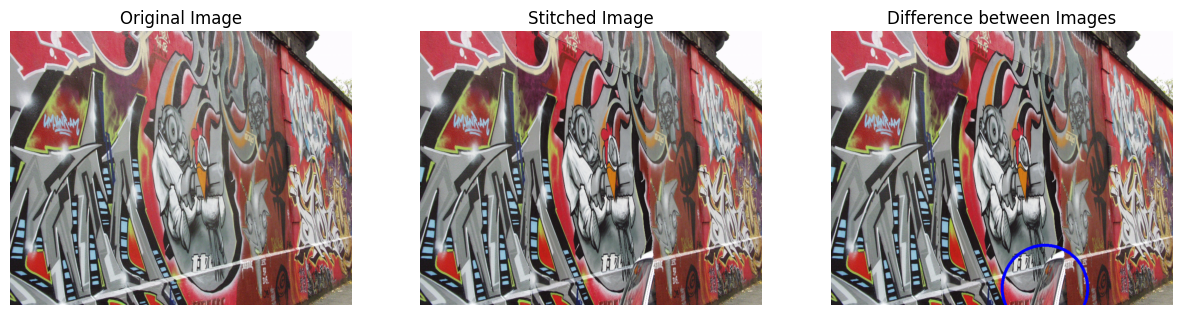

In [50]:
# Open the homography matrix file and read the values
file_path = r"Images/graffities/H1to5p"
H = []

with open(file_path, "r") as file:
    for _ in range(3):
        # Read each line, split it into floats, and append as a tuple to H
        H.append(tuple(map(float, file.readline().strip().split())))

# Convert the list of tuples to a numpy array (3x3 homography matrix)
H = np.array(H)

# Apply the homography transformation to warp img1 to the perspective of img2
warped_img = cv.warpPerspective(img1, H, (img2.shape[1], img2.shape[0]))

# Apply thresholding to create a binary mask from the warped image
_, threshold_mask = cv.threshold(warped_img, 10, 1, cv.THRESH_BINARY_INV)

# Apply the threshold mask to img2 to isolate non-overlapping regions
img2_masked = np.multiply(threshold_mask, img2)

# Blend the masked img2 with the warped img1
blended_image = cv.addWeighted(img2_masked, 1, warped_img, 1, 0)

# Create a plot to display the original, stitched, and marked images
fig, ax = plt.subplots(1, 3, figsize=(15, 12))

# Display original img2
ax[0].imshow(img2)
ax[0].set_title("Original Image")
ax[0].axis("off")

# Display the blended (stitched) image
ax[1].imshow(blended_image)
ax[1].set_title("Stitched Image")
ax[1].axis("off")

# Add a circle annotation to the blended image for visual comparison
blended_image_with_circle = cv.circle(blended_image.copy(), (500, 600), 100, (0, 0, 255), 5)

# Display the blended image with the added circle
ax[2].imshow(blended_image_with_circle)
ax[2].set_title("Difference between Images")
ax[2].axis("off")

# Show the final plot
plt.show()
